Input:  tensor([[ 1.0000,  8.0000, 12.0000, 18.0000, 21.0000,  0.1000,  1.0000,  3.0000,
          2.5000,  2.5000]])
Output:  tensor([[0.4084, 3.1967, 4.2360, 5.3206, 7.2484, 1.9565, 0.9056, 0.9140, 0.9032,
         1.9733]])
Tank levels  tensor([[ 3.7484,  5.1258,  4.7182,  5.4369,  5.3707,  6.1018,  6.0168,  6.7104,
          6.1714,  7.5381, -2.8032]])
Total cost:  tensor(70.0316)
Time taken:  0.10766053199768066 seconds


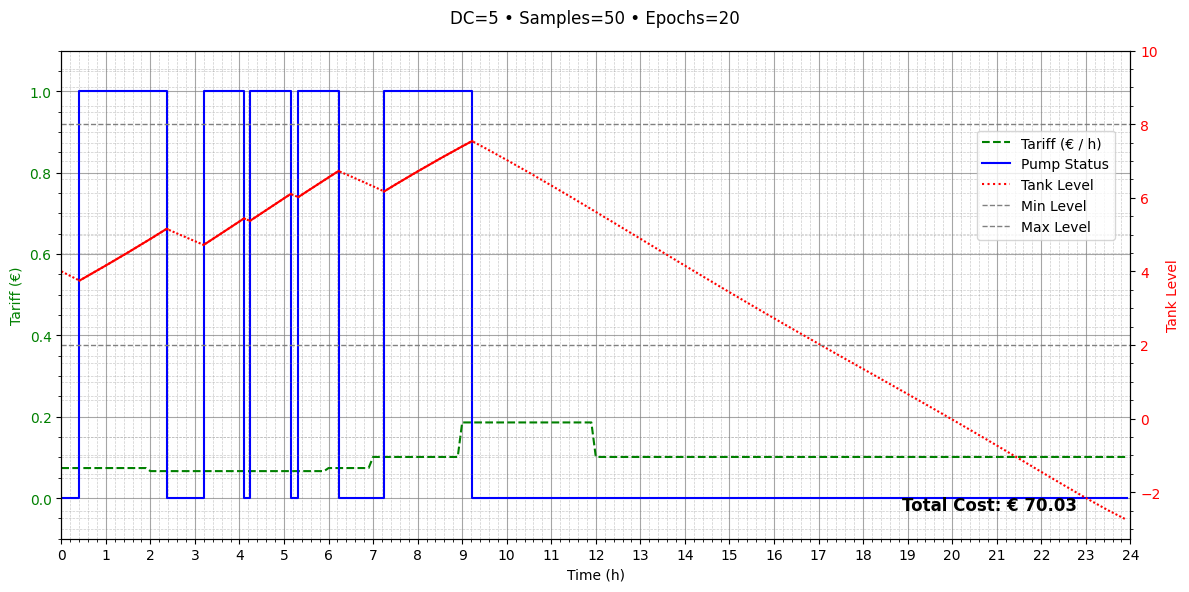

###########################################
Input:  tensor([[ 1.0000,  8.0000, 12.0000, 18.0000, 21.0000,  2.0000,  1.0000,  3.0000,
          2.5000,  2.5000]])
Output:  tensor([[0.5800, 3.3689, 4.6999, 5.8439, 7.9985, 1.9769, 1.1813, 0.8773, 1.1225,
         1.7206]])
Tank levels  tensor([[ 3.6437,  5.0782,  4.6579,  5.6006,  5.5267,  6.2252,  6.0896,  6.9496,
          6.3626,  7.5071, -2.5083]])
Total cost:  tensor(76.8337)
Time taken:  0.0647592544555664 seconds


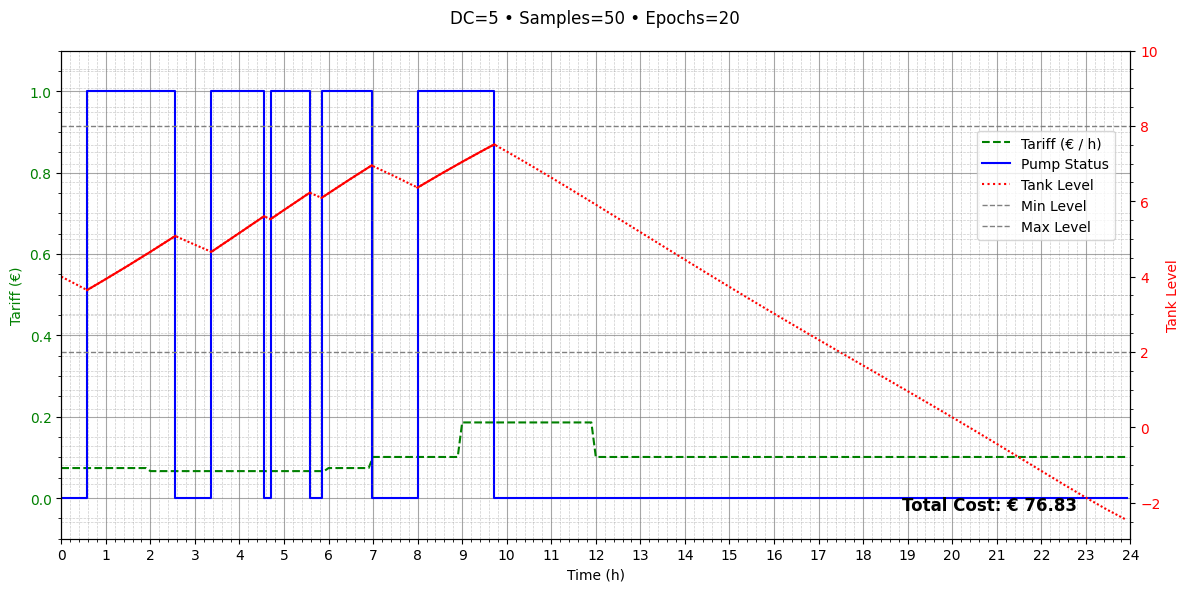

###########################################
Input:  tensor([[ 1.0000,  8.0000, 12.0000, 18.0000, 21.0000,  3.0000,  1.0000,  3.0000,
          2.5000,  2.5000]])
Output:  tensor([[0.6797, 3.5001, 4.7668, 5.7772, 8.0958, 2.0550, 1.0942, 0.7118, 1.2176,
         1.3884]])
Tank levels  tensor([[ 3.5835,  5.0865,  4.6926,  5.5675,  5.4824,  6.0502,  5.8986,  6.8329,
          6.2026,  7.1329, -3.0388]])
Total cost:  tensor(69.1419)
Time taken:  0.062215566635131836 seconds


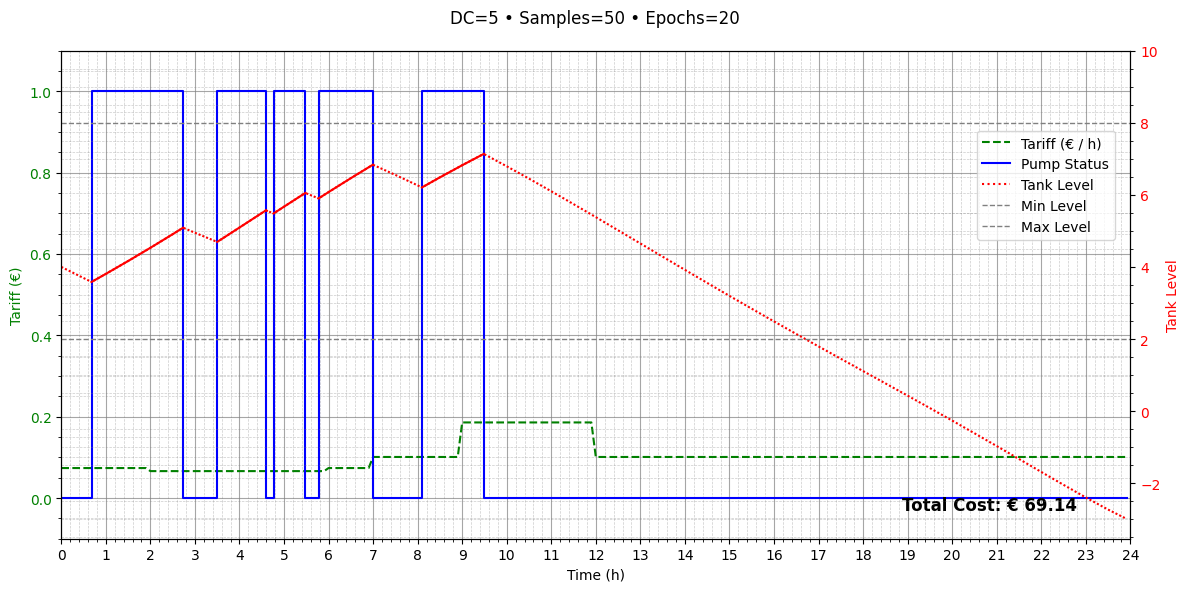

###########################################
Input:  tensor([[ 4.0000,  8.0000, 12.0000, 17.0000, 20.0000,  3.0000,  3.0000,  3.0000,
          2.5000,  2.5000]])
Output:  tensor([[0.3385, 2.2595, 3.6141, 5.1774, 7.4247, 1.3498, 1.1710, 1.2860, 1.5552,
         1.0436]])
Tank levels  tensor([[ 3.7915,  4.7071,  4.4253,  5.3306,  5.2382,  6.2650,  6.1272,  7.3352,
          6.9537,  7.6881, -3.1281]])
Total cost:  tensor(61.6018)
Time taken:  0.06054043769836426 seconds


In [ ]:
import pickle
import numpy as np
import torch
import warnings
from functools import reduce
import matplotlib.pyplot as plt
import torch.nn as nn
import plot_nivel_tanque_new
from method import NNSolver
import os
import plot_nivel_tanque_new as plot_nivel_tanque_new
import utils
import time
import re

torch.xpu.is_available()
warnings.filterwarnings("ignore")
data_path = os.path.join("datasets", "dc_wss", "dc_wss_dataset_dc5_ex100")

with open(data_path, "rb") as f:
    data = pickle.load(f)
#file_name = "model_2025-06-17_14-56-31_dc5_samples8_epochs50_softWeight100.pt"
file_name = "model_2025-09-14_20-31-45_dc5_samples50_epochs20.pt"
file_path = os.path.join("models", file_name)

m = re.search(r"_samples(\d+)_epochs(\d+)\.pt$", file_name)
if not m:
    raise ValueError(f"Nome de arquivo não segue o padrão esperado: {file_name}")

samples = int(m.group(1))
epochs = int(m.group(2))

# ############################################################################

args = {
    "probType": "dc_wss",
    "hiddenSize": 200,
    "batchSize": 200,
    "useCompl": False,
    "corrMode": "full",
    "qtySamples": samples,
    "epochs": epochs,
    'dc': 5,
}

newModel = NNSolver(data, args)
newModel.load_state_dict(torch.load(file_path, map_location=torch.device("cpu")))
newModel.eval()
#print(newModel)
############################################################################
# from FontinhaOptimization
#input_data = torch.tensor([[1, 8, 12, 18, 21, 3, 3, 3, 2.5, 2.5]])
# Random
#input_data = torch.tensor([[1, 5, 6, 7, 17, 3, 0.9, 0.9, 5, 4]])


inputs_data = [
    torch.tensor([[1, 8, 12, 18, 21, 0.1, 1, 3, 2.5, 2.5]]),
    torch.tensor([[1, 8, 12, 18, 21, 2, 1, 3, 2.5, 2.5]]),
    torch.tensor([[1, 8, 12, 18, 21, 3, 1, 3, 2.5, 2.5]]),
    torch.tensor([[4, 8, 12, 17, 20, 3, 3, 3, 2.5, 2.5]]), # FONTINHA
    torch.tensor([[4, 8, 12, 17, 20, 3, 3, 3, 2.5, 2.5]]),
    torch.tensor([[0.3, 4, 12, 19, 21, 5, 2, 3, 2, 1]]),
    torch.tensor([[9, 15, 18, 21, 23, 2, 2, 2, 1, 0.5]]),
    
]


#input_data = torch.tensor([[1, 8, 12, 18, 21, 0.1, 1, 3, 2.5, 2.5]])


for i in range(len(inputs_data)):
    time_init = time.time()
    with torch.no_grad():
        
        output_data = newModel(inputs_data[i].to(torch.float32))
    
    #input_data[i] = inputs_data[i].to(torch.float32)



    print("Input: ", inputs_data[i])
    print("Output: ", output_data)

    total_cost = data.obj_fn_Autograd(output_data, args)[0]
    gt = data.gT_Original(output_data)[0].unsqueeze(0)
    print('Tank levels ', gt)
    print("Total cost: ", total_cost)
    time_end = time.time() - time_init
    print("Time taken: ", time_end, "seconds")
    plot_nivel_tanque_new.plot_nivel_tanque_new(args, output_data[0], total_cost, show=True)
    print('###########################################')

#with torch.no_grad():

#    output_data = newModel(input_data)




In [ ]:


##########################################################################

output_data_ = torch.tensor(output_data[0], dtype=torch.float32).unsqueeze(0)  # Adiciona dimensão de batch
total_cost = data.obj_fn_Autograd(output_data_, args)[0]

print("Output: ", output_data_)

print("Total cost: ", total_cost)

# gT espera um batch, então passamos output_data_ duas vezes
gt = data.gT_Autograd(output_data_, args)[0][:-1]
print('gt ', gt)

# Plot
plot_nivel_tanque_new.plot_nivel_tanque_new(args, output_data_[0], total_cost, show=True)






In [ ]:
import data_system
import OptimAuxFunctionsV2 as op
import torch
import matplotlib.pyplot as plt

d = data_system.data_system([5],[0])

example = torch.tensor([ 
                       [   0.0230,     3.5352,    23.7113,    23.8000,    23.8000,     1.2583,
             4.2545,     0.1000,     0.1000,     0.1000]
          
          
          ])


#example = torch.tensor([
    
#    [ 1.024e+00, 4.384e+00, 6.180e+00, 8.372e+00, 1.653e+01, 3.359e+00, 1.795e+00, 8.262e-01 , 4.026e-01, 3.927e+00]
    
#    ])
    
example_ = example.detach().numpy()

tanks, timeInc, pumps = op.level_plot(example_[0], d)

print(len(tanks['tank0_h']))

print(len(timeInc['StartTime']))

In [ ]:
print(example_)

In [ ]:
plt.plot((timeInc['StartTime']/3600), pumps['pump0_s'], label='Tank 0')


In [ ]:
plt.plot((timeInc['StartTime']/3600), tanks['tank0_h'][:-1], label='Tank 0')


In [ ]:
# converte tempo para horas
time_h = timeInc['StartTime'] / 3600

# plota o nível do tanque
plt.plot(time_h, tanks['tank0_h'][:-1], label='Tank 0')

# adiciona linha horizontal em y=2
plt.axhline(y=2, color='gray', linestyle='--', linewidth=1, label='Nível 2')

# adiciona linha horizontal em y=8
plt.axhline(y=8, color='gray', linestyle='--', linewidth=1, label='Nível 8')

plt.xlabel('Tempo (h)')
plt.ylabel('Altura do tanque')
plt.legend()
plt.show()
